In [567]:
%matplotlib notebook
import pandas as pd 
import numpy as np 
import pandas_datareader as web
from scipy.stats import norm
import datetime
import matplotlib.pyplot as plt
import scipy.optimize as op

In [409]:
# load spx index level 
startdate = '2018-05-29'
enddate = '2020-05-29'
spx = web.DataReader('^GSPC', 'yahoo',startdate,enddate)
# load trades 
trades = pd.read_csv('trades.csv',index_col=['OptionID'])
trades

,OptionDate,ExpirationDate,Spread,Cap,OptionTerm
OptionID,,,,,
1,05/29/2018,05/28/2019,0,100,1
2,05/29/2018,05/28/2019,50,200,1
3,05/29/2018,05/28/2019,100,300,1
4,05/29/2018,05/28/2019,150,400,1
5,05/29/2018,05/28/2019,200,500,1
6,05/29/2018,05/29/2020,0,100,2
7,05/29/2018,05/29/2020,50,200,2
8,05/29/2018,05/29/2020,100,300,2
9,05/29/2018,05/29/2020,150,400,2


In [410]:
def update_trades(trades, notional=1000000):
    trades['OptionDate'] = [datetime.datetime.strptime(d, '%m/%d/%Y') for d in trades['OptionDate']]
    trades['ExpirationDate'] = [datetime.datetime.strptime(d, '%m/%d/%Y') for d in trades['ExpirationDate']]
    tradedate = trades.OptionDate.unique()
    spx_dates = spx.index.values
    spot = spx['Adj Close'][np.in1d( dates, date)].values
    spread = (1 + trades.Spread / 10000) * spot
    cap = (1 + trades.Cap / 10000) * spot
    trades['Dollar Spread'] = spread.values
    trades['Dollar Cap'] = cap.values
    trades['Notional'] = notional
    trades['Units'] = trades['Notional'] / spot
    trades['IsCall'] = True
    
    

In [411]:
update_trades(trades)

In [412]:
trades

,OptionDate,ExpirationDate,Spread,Cap,OptionTerm,Dollar Spread,Dollar Cap,Notional,Units,IsCall
OptionID,,,,,,,,,,
1,2018-05-29,2019-05-28,0,100,1,3044.310059,3074.753159,1000000,328.481653,True
2,2018-05-29,2019-05-28,50,200,1,3059.531609,3105.196260,1000000,328.481653,True
3,2018-05-29,2019-05-28,100,300,1,3074.753159,3135.639360,1000000,328.481653,True
4,2018-05-29,2019-05-28,150,400,1,3089.974709,3166.082461,1000000,328.481653,True
5,2018-05-29,2019-05-28,200,500,1,3105.196260,3196.525562,1000000,328.481653,True
6,2018-05-29,2020-05-29,0,100,2,3044.310059,3074.753159,1000000,328.481653,True
7,2018-05-29,2020-05-29,50,200,2,3059.531609,3105.196260,1000000,328.481653,True
8,2018-05-29,2020-05-29,100,300,2,3074.753159,3135.639360,1000000,328.481653,True
9,2018-05-29,2020-05-29,150,400,2,3089.974709,3166.082461,1000000,328.481653,True


In [547]:
# assumption 
vol_atm= 0.17
vol_otm_call = 0.14
vol_otm_put = 0.23
rf = 0.015
div = 0.01

In [322]:
# BS model 
def bsprice(spot, strike, ttm, vol, rf, div, iscall):
    futureprice = spot * np.exp((rf - div) * ttm)
    d1 = (1 / (vol * np.sqrt(ttm))) * (np.log(spot / strike) + (rf - div + 0.5 * vol ** 2) * ttm)
    d2 = d1 - vol * np.sqrt(ttm)
    if iscall:
        return np.exp(-rf * ttm) * (futureprice * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        return np.exp(-rf * ttm) * (strike * norm.cdf(-d2) - futureprice * norm.cdf(-d1))

In [323]:
# test bs model 
spot = 2689.86
ttm = (trades['ExpirationDate'] - trades['OptionDate']) / pd.Timedelta(1, unit='d') / 365
price = bsprice(spot,trades['Dollar Spread'], ttm, vol_atm, rf, div, True)
price

OptionID
1     186.405022
2     180.151037
3     174.051389
4     168.104869
5     162.569272
6     264.532838
7     258.470194
8     252.514689
9     246.665552
10    240.921976
dtype: float64

In [353]:
# calculate spread 
def bsprice_spread(spot,spread,cap,ttm, vol_spread,vol_cap,rf, div):
    spread_price = bsprice(spot,spread,ttm, vol_spread, rf, div,True)
    cap_price = bsprice(spot,cap,ttm, vol_cap, rf, div,True)
    return spread_price - cap_price
  

In [390]:
def hedging_strategy(spot,spread,cap,ttm, vol_atm,vol_otm,rf, div):
    # long put
    put_price = bsprice(spot,spread,ttm, vol_atm, rf, div, False)
    # long future 
    future_price = (spot - spread) * (1 + (rf- div)/360)
    #short call 
    call_price = bsprice(spot,cap,ttm, vol_otm, rf, div, True)
    return put_price + future_price - call_price

In [355]:
# test bsprice_spread
spot = 2689.86
ttm = (trades['ExpirationDate'] - trades['OptionDate']) / pd.Timedelta(1, unit='d') / 365
price = bsprice_spread(spot,trades['Dollar Spread'],trades['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div)
price

OptionID
1     44.150328
2     49.663685
3     54.601684
4     58.980730
5     62.870366
6     56.403697
7     62.108141
8     67.410165
9     72.318222
10    76.841649
dtype: float64

In [356]:
# test hedging strategy
spot = 2689.86
ttm = (trades['ExpirationDate'] - trades['OptionDate']) / pd.Timedelta(1, unit='d') / 365
price = hedging_strategy(spot,trades['Dollar Spread'],trades['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div)
price

OptionID
1     30.904019
2     36.217499
3     40.955622
4     45.134792
5     48.786437
6     30.134075
7     35.440308
8     40.344123
9     44.853970
10    48.979187
dtype: float64

In [357]:
# payoff check call 
trade = trades.iloc[0,:]
spot_range = range(2683,2720,1)
payoff_callspread = []
for spot in spot_range:
    price = bsprice_spread(spot,trade['Dollar Spread'],trade['Dollar Cap'],0, vol_atm,vol_otm_call,rf, div)
    payoff_callspread.append(price)
    
# payoff check strategy
payoff_putstg = []
for spot in spot_range:
    price = hedging_strategy(spot,trade['Dollar Spread'],trade['Dollar Cap'],0, vol_atm,vol_otm_call,rf, div)
    payoff_putstg.append(price)
    


/home/leftychen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


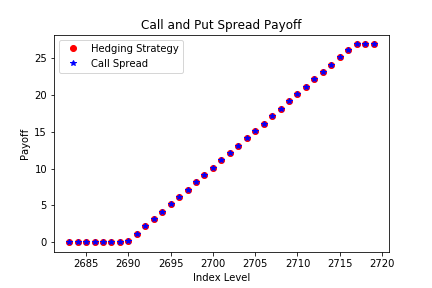

In [358]:
fig, ax = plt.subplots(1, 1)
ax.plot(spot_range, payoff_putstg,'ro',label='Hedging Strategy')
ax.plot(spot_range, payoff_callspread,'b*', label='Call Spread')
ax.set_title('Call and Put Spread Payoff')
ax.set_xlabel('Index Level')
ax.set_ylabel('Payoff')
ax.legend()

In [359]:
# valuation check 
# payoff check call 
trade = trades.iloc[0,:]
spot_range = range(2400,3200,5)
val_callspread = []
for spot in spot_range:
    price = bsprice_spread(spot,trade['Dollar Spread'],trade['Dollar Cap'],1, vol_atm,vol_otm_call,rf, div)
    val_callspread.append(price)
    
# payoff check strategy
val_putstg = []
for spot in spot_range:
    price = hedging_strategy(spot,trade['Dollar Spread'],trade['Dollar Cap'],1, vol_atm,vol_otm_call,rf, div)
    val_putstg.append(price)
    

<IPython.core.display.Javascript object>


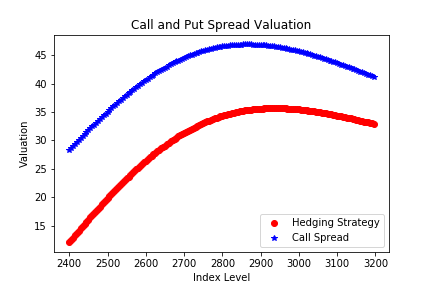

In [345]:
fig, ax = plt.subplots(1, 1)
ax.plot(spot_range, val_putstg,'ro',label='Hedging Strategy')
ax.plot(spot_range, val_callspread,'b*', label='Call Spread')
ax.set_title('Call and Put Spread Valuation')
ax.set_xlabel('Index Level')
ax.set_ylabel('Valuation')
ax.legend()

In [538]:
# vol check 
# payoff check call
spot = 2689.86
trade = trades.iloc[0,:]
vol_range = np.arange(0.1,0.5,0.01)
vol_callspread = []
for vol in vol_range:
    price = bsprice_spread(spot,trade['Dollar Spread'],trade['Dollar Cap'],1, vol_atm,vol_otm_call,rf, div)
    vol_callspread.append(price)
    
# payoff check strategy
vol_putstg = []
for vol in vol_range:
    price = hedging_strategy(spot,trade['Dollar Spread'],trade['Dollar Cap'],1, vol,vol * vol_otm_call/vol_atm,rf, div)
    vol_putstg.append(price)
    

<IPython.core.display.Javascript object>


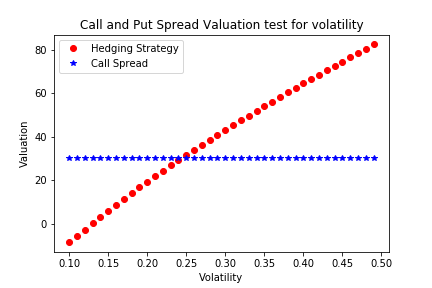

In [539]:
fig, ax = plt.subplots(1, 1)
ax.plot(vol_range, vol_putstg,'ro',label='Hedging Strategy')
ax.plot(vol_range, vol_callspread,'b*', label='Call Spread')
ax.set_title('Call and Put Spread Valuation test for volatility')
ax.set_xlabel('Volatility')
ax.set_ylabel('Valuation')
ax.legend()

In [377]:
def greeks_delta(stg,spot,spread,cap,ttm, vol_atm,vol_otm,rf, div, shock):
    spot_up = spot * (1 + shock)
    spot_dn = spot * (1 - shock)
    price_up = stg(spot_up,spread,cap,ttm, vol_atm,vol_otm,rf, div)
    price_dn = stg(spot_dn,spread,cap,ttm, vol_atm,vol_otm,rf, div)
    return (price_up - price_dn) / (2 * spot * shock)

In [381]:
# test bs greek
spot = 2689.86
trade = trades.iloc[0,:]
bs_delta = greeks_delta(bsprice_spread,spot,trade['Dollar Spread'],trade['Dollar Cap'],1,vol_atm, vol_otm_call,rf, div, 0.1)
bs_delta

0.030589697094402676

In [382]:
# test heding strategy
spot = 2689.86
trade = trades.iloc[0,:]
stg_delta = greeks_delta(hedging_strategy,spot,trade['Dollar Spread'],trade['Dollar Cap'],1,vol_atm, vol_otm_call,rf, div, 0.1)
stg_delta

0.04055375223412298

In [388]:
# delta check 
# payoff check call
spot_range = range(2400,3200,5)
trade = trades.iloc[0,:]
delta_callspread = []
for spot in spot_range:
    price = greeks_delta(bsprice_spread,spot,trade['Dollar Spread'],trade['Dollar Cap'],1,vol_atm, vol_otm_call,rf, div, 0.1)
    delta_callspread.append(price)
    
# payoff check strategy
delta_putstg = []
for spot in spot_range:
    price = greeks_delta(hedging_strategy,spot,trade['Dollar Spread'],trade['Dollar Cap'],1, vol_atm, vol_otm_call,rf, div,0.1)
    delta_putstg.append(price)
    

<IPython.core.display.Javascript object>


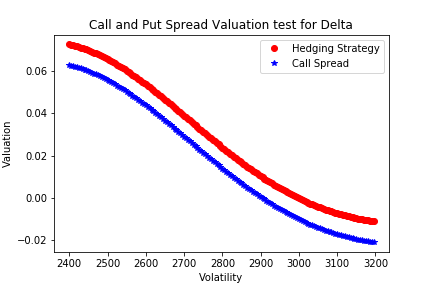

In [389]:
fig, ax = plt.subplots(1, 1)
ax.plot(spot_range, delta_putstg,'ro',label='Hedging Strategy')
ax.plot(spot_range, delta_callspread,'b*', label='Call Spread')
ax.set_title('Call and Put Spread Valuation test for Delta')
ax.set_xlabel('Volatility')
ax.set_ylabel('Valuation')
ax.legend()

In [485]:
# back testing 1 year
trades_1y = trades[trades['OptionTerm'] == 1]
expdate = trades_1y['ExpirationDate'].unique()
spx_dates = spx.index.values
spx_dates_1y = spx_dates[spx.index.values < expdate]
backtesting_callspread = []
for date in spx_dates_1y:
    spot = spx['Adj Close'][date]
    ttm = (trades_1y['ExpirationDate'] - date) / pd.Timedelta(1, unit='d') / 365
    price = bsprice_spread(spot,trades_1y['Dollar Spread'],trades_1y['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div)
    backtesting_callspread.append(price.sum() * trades_1y['Units'].sum())
backtesting_stg = []

for date in spx_dates_1y:
    spot = spx['Adj Close'][date]
    ttm = (trades_1y['ExpirationDate'] - date) / pd.Timedelta(1, unit='d') / 365
    price = hedging_strategy(spot,trades_1y['Dollar Spread'],trades_1y['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div)
    backtesting_stg.append(price.sum() * trades_1y['Units'].sum())
    

<IPython.core.display.Javascript object>


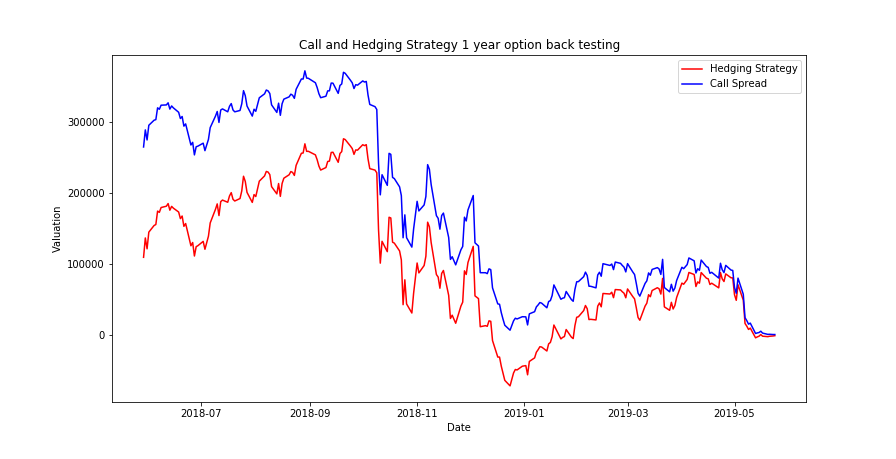

In [486]:
fig, ax = plt.subplots(1, 1)
ax.plot(spx_dates_1y, backtesting_stg,'r-',label='Hedging Strategy')
ax.plot(spx_dates_1y, backtesting_callspread,'b-', label='Call Spread')
ax.set_title('Call and Hedging Strategy 1 year option back testing')
ax.set_xlabel('Date')
ax.set_ylabel('Valuation')
ax.legend()

In [487]:
# back testing 2 year
trades_2y = trades[trades['OptionTerm'] == 2]
expdate = trades_2y['ExpirationDate'].unique()
spx_dates = spx.index.values
spx_dates_2y = spx_dates[spx.index.values < expdate]
backtesting_callspread_2y = []
for date in spx_dates_2y:
    spot = spx['Adj Close'][date]
    ttm = (trades_2y['ExpirationDate'] - date) / pd.Timedelta(1, unit='d') / 365
    price = bsprice_spread(spot,trades_2y['Dollar Spread'],trades_2y['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div)
    backtesting_callspread_2y.append(price.sum() * trades_1y['Units'].sum())

    
backtesting_stg_2y = []
for date in spx_dates_2y:
    spot = spx['Adj Close'][date]
    ttm = (trades_2y['ExpirationDate'] - date) / pd.Timedelta(1, unit='d') / 365
    price = hedging_strategy(spot,trades_2y['Dollar Spread'],trades_2y['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div)
    backtesting_stg_2y.append(price.sum() * trades_1y['Units'].sum())
    

<IPython.core.display.Javascript object>


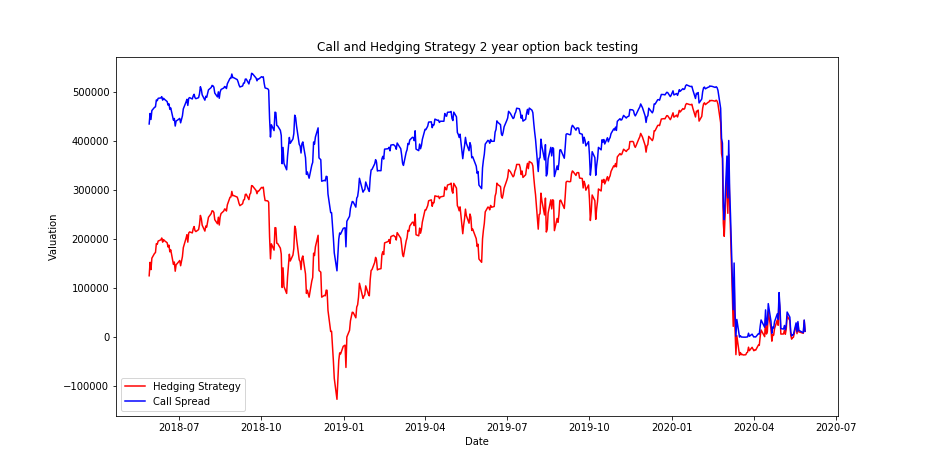

In [489]:
fig, ax = plt.subplots(1, 1)
ax.plot(spx_dates_2y, backtesting_stg_2y,'r-',label='Hedging Strategy')
ax.plot(spx_dates_2y, backtesting_callspread_2y,'b-', label='Call Spread')
ax.set_title('Call and Hedging Strategy 2 year option back testing')
ax.set_xlabel('Date')
ax.set_ylabel('Valuation')
ax.legend()

In [490]:
# back testing delta 1 year
trades_1y = trades[trades['OptionTerm'] == 1]
expdate = trades_1y['ExpirationDate'].unique()
spx_dates = spx.index.values
spx_dates_1y = spx_dates[spx.index.values < expdate]
backtesting_delta_callspread = []
for date in spx_dates_1y:
    spot = spx['Adj Close'][date]
    ttm = (trades_1y['ExpirationDate'] - date) / pd.Timedelta(1, unit='d') / 365
    price = greeks_delta(bsprice_spread,spot,trades_1y['Dollar Spread'],trades_1y['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div,0.1)
    backtesting_delta_callspread.append(price.sum() * trades_1y['Units'].sum())
backtesting_delta_stg = []

for date in spx_dates_1y:
    spot = spx['Adj Close'][date]
    ttm = (trades_1y['ExpirationDate'] - date) / pd.Timedelta(1, unit='d') / 365
    price = greeks_delta(hedging_strategy,spot,trades_1y['Dollar Spread'],trades_1y['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div,0.1)
    backtesting_delta_stg.append(price.sum() * trades_1y['Units'].sum())
    

<IPython.core.display.Javascript object>


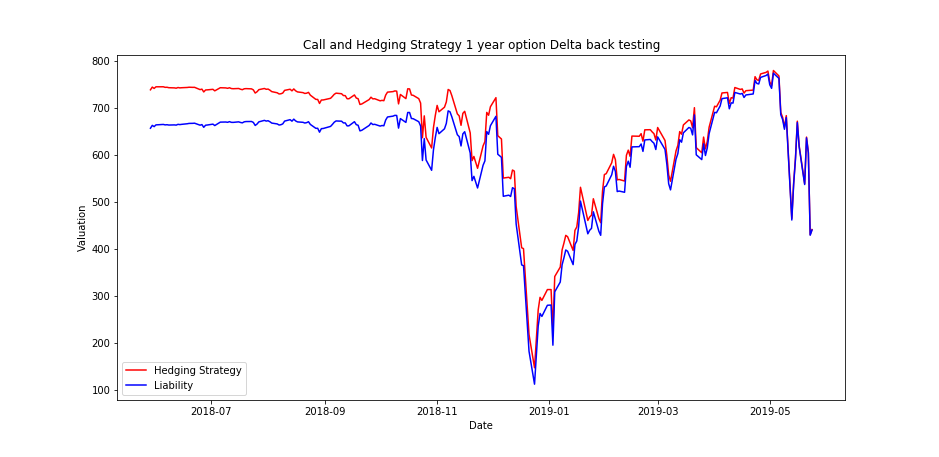

In [491]:
fig, ax = plt.subplots(1, 1)
ax.plot(spx_dates_1y, backtesting_delta_stg,'r-',label='Hedging Strategy')
ax.plot(spx_dates_1y, backtesting_delta_callspread,'b-', label='Liability')
ax.set_title('Call and Hedging Strategy 1 year option Delta back testing')
ax.set_xlabel('Date')
ax.set_ylabel('Valuation')
ax.legend()

In [492]:
# back testing delta 2 year
trades_2y = trades[trades['OptionTerm'] == 2]
expdate = trades_2y['ExpirationDate'].unique()
spx_dates = spx.index.values
spx_dates_2y = spx_dates[spx.index.values < expdate]
backtesting_delta_callspread_2y = []
for date in spx_dates_2y:
    spot = spx['Adj Close'][date]
    ttm = (trades_2y['ExpirationDate'] - date) / pd.Timedelta(1, unit='d') / 365
    price = greeks_delta(bsprice_spread,spot,trades_2y['Dollar Spread'],trades_2y['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div,0.1)
    backtesting_delta_callspread_2y.append(price.sum() * trades_1y['Units'].sum())

    
backtesting_delta_stg_2y = []
for date in spx_dates_2y:
    spot = spx['Adj Close'][date]
    ttm = (trades_2y['ExpirationDate'] - date) / pd.Timedelta(1, unit='d') / 365
    price = greeks_delta(hedging_strategy,spot,trades_2y['Dollar Spread'],trades_2y['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div,0.1)
    backtesting_delta_stg_2y.append(price.sum() * trades_1y['Units'].sum())
    

<IPython.core.display.Javascript object>


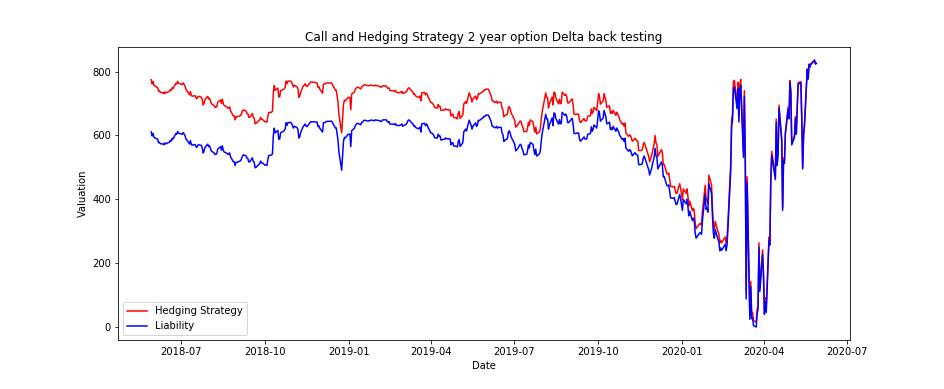

In [493]:
fig, ax = plt.subplots(1, 1)
ax.plot(spx_dates_2y, backtesting_delta_stg_2y,'r-',label='Hedging Strategy')
ax.plot(spx_dates_2y, backtesting_delta_callspread_2y,'b-', label='Liability')
ax.set_title('Call and Hedging Strategy 2 year option Delta back testing')
ax.set_xlabel('Date')
ax.set_ylabel('Valuation')
ax.legend()

In [691]:
def calcuate_total(allocation, date,trades,spot,vol_atm, vol_atm_call, rf,div):
    stg_trades = trades[allocation > 0]
    cs_trades = trades[allocation < 0]
    stg_price = 0
    stg_delta = 0
    if len(stg_trades) != 0:
        ttm_stg = (stg_trades['ExpirationDate'] - date) / pd.Timedelta(1, unit='d') / 365
        stg_price = hedging_strategy(spot,stg_trades['Dollar Spread'],stg_trades['Dollar Cap'],ttm_stg, vol_atm,vol_otm_call,rf, div)
        stg_delta = greeks_delta(hedging_strategy,spot,stg_trades['Dollar Spread'],stg_trades['Dollar Cap'],ttm_stg, vol_atm,vol_otm_call,rf, div,0.1)
        stg_price = (stg_price * stg_trades['Units']).sum()
        stg_delta = (stg_delta * stg_trades['Units']).sum()
    cs_price = 0
    cs_delta = 0
    if len(cs_trades) != 0:
        ttm_cs = (cs_trades['ExpirationDate'] - date) / pd.Timedelta(1, unit='d') / 365
        cs_price = bsprice_spread(spot,cs_trades['Dollar Spread'],cs_trades['Dollar Cap'],ttm_cs, vol_atm,vol_otm_call,rf, div)
        cs_delta = greeks_delta(bsprice_spread,spot,cs_trades['Dollar Spread'],cs_trades['Dollar Cap'],ttm_cs, vol_atm,vol_otm_call,rf, div,0.1)
        cs_price = (cs_price * cs_trades['Units']).sum()
        cs_delta = (cs_delta * cs_trades['Units']).sum()
    price = stg_price + cs_price
    delta_assets = stg_delta + cs_delta

    #liability 
    liab_price = 0
    liab_delta = 0
    ttm = (trades['ExpirationDate'] - date) / pd.Timedelta(1, unit='d') / 365
    liab_price = bsprice_spread(spot,trades['Dollar Spread'],trades['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div)
    liab_delta = greeks_delta(bsprice_spread,spot,trades['Dollar Spread'],trades['Dollar Cap'],ttm, vol_atm,vol_otm_call,rf, div,0.1)
    delta_liab = (liab_delta * trades['Units']).sum()
    liab_price = (liab_price * trades['Units']).sum()
    return price,delta_assets,liab_price,delta_liab

In [692]:
# optimization
def trade_opt_lossfunc(initital,date,trades,spot,vol_atm,vol_atm_call, rf,div):
    price,delta_assets,liab_price,delta_liab = calcuate_total(initital,date,trades,spot,vol_atm,vol_atm_call, rf,div)
    return price + (delta_assets - delta_liab) ** 2

In [699]:
# test lost function
spot = 2689.86
date = spx.index.values[0]
init = np.random.randn(len(trades))
trade_opt_lossfunc(init,date,trades,spot,vol_atm,vol_otm_call, rf,div)

121316.86471643715

In [700]:
cons = {'type': 'eq', 'fun': lambda x: (x * (x-1)).sum()}
res = op.minimize(fun=trade_opt_lossfunc,x0=init, args=(date,trades,spot,vol_atm,vol_otm_call, rf,div),method='SLSQP',constraints=cons)
res

     fun: 72856.5776553392
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.16393929,  0.14233955,  0.38081829, -0.55770826, -0.18893542,
       -0.04052733,  0.18460868,  0.53444822,  0.22438296,  0.07248779])

In [701]:
# coost saving
spot = 2689.86
date = spx.index.values[0]
price,delta_assets,liab_price,delta_liab  = calcuate_total(res.x,date,trades,spot,vol_atm,vol_otm_call, rf,div)

In [702]:
print('cost for heding Strategy is ' + str(price / trades['Notional'].sum()))
print('cost for static hedge is ' + str(liab_price/ trades['Notional'].sum()))
print('delta for hedging strategy is ' + str(delta_assets))
print('delta for static hedge is ' + str(delta_liab))

cost for heding Strategy is 0.007157039982966734
cost for static hedge is 0.013982375632493972
delta for hedging strategy is 289.40173895108956
delta for static hedge is 253.53841749766204


In [703]:
# all hedging strategy 
spot = 2689.86
date = spx.index.values[0]
price,delta_assets,liab_price,delta_liab  = calcuate_total(np.ones((len(trades),1)),date,trades,spot,vol_atm,vol_otm_call, rf,div)

In [704]:
print('cost for heding Strategy is ' + str(price / trades['Notional'].sum()))
print('cost for static hedge is ' + str(liab_price/ trades['Notional'].sum()))
print('delta for hedging strategy is ' + str(delta_assets))
print('delta for static hedge is ' + str(delta_liab))

cost for heding Strategy is 0.004681087482953268
cost for static hedge is 0.013982375632493972
delta for hedging strategy is 302.4476933507271
delta for static hedge is 253.53841749766204
